## Setup 

In [1]:
% matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

In [2]:
# setup data
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

# PCA

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [4]:
X2D.shape

(60, 2)

In [5]:
# PC轴信息
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [6]:
# 数据映射百分比
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [7]:
# Choosing the Right Number of Dimensions
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [8]:
cumsum >= 0.95

array([False,  True,  True])

In [9]:
np.argmax([9, 10, 10, 4, 5, 6, 7])

1

In [10]:
# 当n_components参数在0~1.0之间时，自动选择训练集采用率达到该值的维度
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

In [11]:
# Try minst dataset
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]
X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [12]:
minst_pca = PCA()
minst_pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [13]:
cumsum = np.cumsum(minst_pca.explained_variance_ratio_)

Dimension(95%): 154


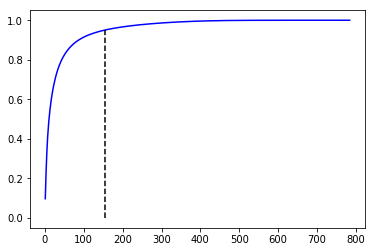

In [14]:
d = np.argmax(cumsum > 0.95) + 1
print('Dimension(95%):', d)
plt.plot(range(1, len(cumsum) + 1), cumsum, 'b-')
plt.plot([d, d], [0, 0.95], 'k--')
plt.show()

In [15]:
# compression
def show_digit(digit_image_data):
    image_matrix = digit_image_data.reshape(28, 28)
    plt.imshow(image_matrix, cmap=matplotlib.cm.binary, interpolation='nearest')
    plt.axis("off")
    plt.show()
minst_pca = PCA(n_components = 0.95)
minst_pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [16]:
print('Dimensions:', len(minst_pca.components_))

Dimensions: 154


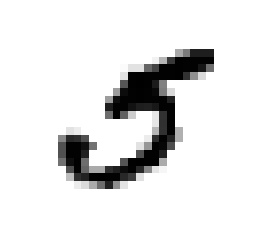

In [17]:
test_idx = 36000
show_digit(X_train[test_idx])

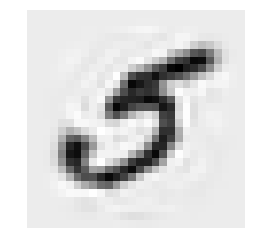

In [18]:
# recover
X_train_reduced = minst_pca.transform([X_train[test_idx]])
X_train_recovered = minst_pca.inverse_transform([X_train_reduced])
show_digit(X_train_recovered[0])

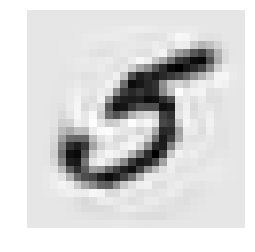

CPU times: user 59.5 s, sys: 6.96 s, total: 1min 6s
Wall time: 29.2 s


In [19]:
%%time
from sklearn.decomposition import IncrementalPCA
n_batches = 100
# 增量PCA训练，可以减少内存使用
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
X_train_reduced = inc_pca.transform([X_train[test_idx]])
X_train_recovered = inc_pca.inverse_transform([X_train_reduced])
show_digit(X_train_recovered[0])

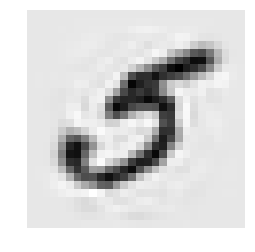

CPU times: user 23.7 s, sys: 1.6 s, total: 25.3 s
Wall time: 7 s


In [20]:
%%time
# Randomized PCA, a stochastic algorithm, much faster
rnd_pca = PCA(n_components=154, svd_solver='randomized') # 无法使用 n_components=0.95
rnd_pca.fit(X_train)
X_train_reduced = rnd_pca.transform([X_train[test_idx]])
X_train_recovered = rnd_pca.inverse_transform([X_train_reduced])
show_digit(X_train_recovered[0])

## Kernel PCA

In [21]:
# prepared data set
randomized_indices = np.random.permutation(60000)
X_train_mini = X_train[randomized_indices[:3000]]
y_train_mini = y_train[randomized_indices[:3000]]

In [22]:
%%time
# test normal prediction
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_jobs=-1)
forest_clf.fit(X_train, y_train)

CPU times: user 7.24 s, sys: 177 ms, total: 7.42 s
Wall time: 1.61 s


In [23]:
%%time
# build PCA with GridSearchCV
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
pca_pl = Pipeline([
    ('kpca', KernelPCA(n_components=154)),
    ('forest_clf', RandomForestClassifier(n_jobs=-1)),
])
param_grid = [{
    "kpca__gamma": [0.03, 0.1, 0.3],
    'kpca__kernel':['rbf', 'linear'],
}]
grid_search = GridSearchCV(pca_pl, param_grid, cv=3, return_train_score=True)
grid_search.fit(X_train_mini, y_train_mini)
# 38.9 s for 3000 samples

CPU times: user 1min 12s, sys: 3.9 s, total: 1min 16s
Wall time: 39.1 s


In [24]:
cvres = grid_search.cv_results_
for mean_score, params in sorted(zip(cvres['mean_test_score'], cvres['params']), key=lambda x: x[0], reverse=True):
    print(mean_score, params)

0.7093333333333334 {'kpca__gamma': 0.3, 'kpca__kernel': 'linear'}
0.7086666666666667 {'kpca__gamma': 0.03, 'kpca__kernel': 'linear'}
0.7053333333333334 {'kpca__gamma': 0.1, 'kpca__kernel': 'linear'}
0.096 {'kpca__gamma': 0.03, 'kpca__kernel': 'rbf'}
0.096 {'kpca__gamma': 0.1, 'kpca__kernel': 'rbf'}
0.096 {'kpca__gamma': 0.3, 'kpca__kernel': 'rbf'}


In [25]:
# KernelPCA在进行inverse_transform操作的时候会有误差，
# 我们利用这个误差来作为衡量标准，找出误差最小的PCA转换，即是最优解
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X_train_mini)
X_preimage = rbf_pca.inverse_transform(X_reduced)
# calcualte error
from sklearn.metrics import mean_squared_error
mean_squared_error(X_train_mini, X_preimage)

4341.224949424845

## LLE

In [30]:
# setup data
from sklearn.datasets import make_swiss_roll
X_sr, y_sr = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [31]:
# LLE
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)

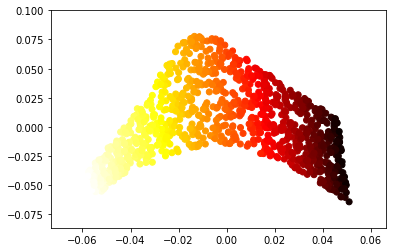

In [32]:
plt.scatter(X_sr_reduced[:, 0], X_sr_reduced[:, 1], c=y_sr, cmap=plt.cm.hot)
plt.show()